Hello everyone! So far on this journey, we’ve managed to build our very own version of GPT-2, and later brought in the open-source weights provided by OpenAI. We walked through the idea of pretraining—imagining what it would take to train on massive datasets for countless epochs with enormous resources—before grounding ourselves with the already available pretrained weights. Now we are going to fine-tune the model to work as an email classifier, giving us our first real taste of a specific task.

In [ ]:
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [ ]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
df['Label'].value_counts()

,count
Label,
ham,4825
spam,747


In [ ]:
def create_balanced_dataset(df):

    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]

    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [ ]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [ ]:
balanced_df

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


<div class="alert alert-block alert-success">

We create a random_split function to split the dataset into three parts: 70% for
training, 10% for validation, and 20% for testing.

(These ratios are common in machine
learning to train, adjust, and evaluate models.)    
</div>

In [ ]:
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder


In [ ]:
print(len(train_df))
print(len(validation_df))
print(len(test_df))

1045
149
300


In [ ]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

<div class="alert alert-block alert-success">

Previously, we utilized a sliding window technique to generate uniformly
sized text chunks, which were then grouped into batches for more efficient model training.
Each chunk functioned as an individual training instance

In the case of email spam classification, have two primary options:

(1) Truncate all messages to the length of the shortest message in the
dataset or batch.

(2) Pad all messages to the length of the longest message in the dataset or
batch.
    
</div>

<div class="alert alert-block alert-warning">

Option 1 is computationally cheaper, but it may result in significant information loss if
shorter messages are much smaller than the average or longest messages, potentially
reducing model performance.

So, we opt for the second option, which preserves the entire
content of all messages.

To implement option 2, where all messages are padded to the length of the longest
message in the dataset, we add padding tokens to all shorter messages.

For this purpose,
we use "<|endoftext|>" as a padding token, as discussed in chapter 2.

    
However, instead of appending the string "<|endoftext|>" to each of the text messages
directly, we can add the token ID corresponding to "<|endoftext|>" to the encoded text
</div>

<div class="alert alert-block alert-success">

As we have seen earlier, we first need to implement a PyTorch Dataset, which
specifies how the data is loaded and processed, before we can instantiate the data loaders.
    
</div>

<div class="alert alert-block alert-success">

For this purpose, we define the SpamDataset class.

This SpamDataset class handles several key tasks: it identifies the
longest sequence in the training dataset, encodes the text messages, and ensures that all
other sequences are padded with a padding token to match the length of the longest
sequence.
    
</div>

In [ ]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length

            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

<div class="alert alert-block alert-info">

Step 1: Pre-tokenize texts
    
Step 2: Truncate sequences if they are longer than max_length
    
Step 3: Pad sequences to the longest sequence

</div>

<div class="alert alert-block alert-warning">

The SpamDataset class loads data from the CSV files we created earlier, tokenizes the text
using the GPT-2 tokenizer from tiktoken and allows us to pad or truncate the sequences to
a uniform length determined by either the longest sequence or a predefined maximum
length.
</div>

<div class="alert alert-block alert-success">

This ensures each input tensor is of the same size, which is necessary to create the
batches in the training data loader we implement next:
    
</div>

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


<div class="alert alert-block alert-info">

The code outputs 120, showing that the longest sequence contains no more than 120
tokens, a common length for text messages.
                       
It's worth noting that the model can handle
sequences of up to 1,024 tokens, given its context length limit.

If your dataset includes
longer texts, you can pass max_length=1024 when creating the training dataset in the
preceding code to ensure that the data does not exceed the model's supported input
(context) length.

</div>

<div class="alert alert-block alert-success">

Next, we pad the validation and test sets to match the length of the longest training
sequence.

It's important to note that any validation and test set samples exceeding the
length of the longest training example are truncated using
encoded_text[:self.max_length] in the SpamDataset code we defined earlier.

This
truncation is optional; you could also set max_length=None for both validation and test
sets, provided there are no sequences exceeding 1,024 tokens in these sets
</div>

In [ ]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

print(test_dataset.max_length)

120


<div class="alert alert-block alert-success">

Using the datasets as inputs, we can instantiate the data loaders similarly to what we did earlier.

However, in this case, the targets represent class labels rather than the next
tokens in the text.

For instance, choosing a batch size of 8, each batch will consist of 8
training examples of length 120 and the corresponding class label of each example.
</div>

In [ ]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

<div class="alert alert-block alert-success">

To ensure that the data loaders are working and are indeed returning batches of the
expected size, we iterate over the training loader and then print the tensor dimensions of
the last batch:

</div>

In [ ]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


<div class="alert alert-block alert-info">

As we can see, the input batches consist of 8 training examples with 120 tokens each, as
expected.

The label tensor stores the class labels corresponding to the 8 training examples.

</div>

<div class="alert alert-block alert-success">

Lastly, to get an idea of the dataset size, let's print the total number of batches in each
dataset:
</div>

In [ ]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [ ]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [ ]:
import torch
import torch.nn as nn

In [ ]:
GPT_CONFIG_124M = {
    'vocab_size' : 50257,
    'emb_dim' : 768,
    'context_length' : 256,
    'n_heads' : 12,
    'n_layers' : 12,
    'dropout_rate' : 0.1,
    'qkv_bias' : False,
    'model_name' : 'gpt-2'
}

In [ ]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
      super().__init__() # d_in, d_out, context_length, dropout, num_heads, qkv_bias=False
      self.attn = MultiHeadAttention(cfg['emb_dim'], cfg['emb_dim'], cfg['context_length'], cfg['dropout_rate'], cfg['n_heads'], cfg['qkv_bias'])
      self.ffn = FeedForward(cfg)
      self.norm1 = nn.LayerNorm(cfg['emb_dim'])
      self.norm2 = nn.LayerNorm(cfg['emb_dim'])
      self.dropout = nn.Dropout(cfg['dropout_rate'])

  def forward(self, x):
      shortcut = x
      x = self.norm1(x)
      x = self.attn(x)
      x = self.dropout(x)
      x = shortcut + x

      shortcut = x
      x = self.norm2(x)
      x = self.ffn(x)
      x = self.dropout(x)
      x = shortcut + x

      return x

In [ ]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
      super().__init__()
      self.token_embedding = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
      self.positional_embedding = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
      self.dropout = nn.Dropout(cfg['dropout_rate'])

      self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

      self.final_norm = nn.LayerNorm(cfg['emb_dim'])
      self.lm_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

  def forward(self, x):
      batch_size, seq_len = x.shape
      token_embeddings = self.token_embedding(x)
      position_embeddings = self.positional_embedding(torch.arange(seq_len, device=x.device))
      input_embeddings = token_embeddings + position_embeddings
      x = self.dropout(input_embeddings)
      x = self.trf_blocks(x)
      x = self.final_norm(x)
      x = self.lm_head(x)
      return x

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:].to(idx.device) # Explicitly move to device
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [ ]:
!pip install tensorflow>=2.15.0 tqdm>=4.66

In [ ]:
import tensorflow as tf
import tqdm

print("TensorFlow version:", tf.__version__)
print("tqdm version:", tqdm.__version__)

TensorFlow version: 2.19.0
tqdm version: 4.67.1


In [ ]:
from gpt_download3 import download_and_load_gpt2

In [ ]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/checkpoint


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/encoder.json


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/hparams.json


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.index


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.meta


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [ ]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [ ]:
GPT_CONFIG_124M

{'vocab_size': 50257,
 'emb_dim': 768,
 'context_length': 256,
 'n_heads': 12,
 'n_layers': 12,
 'dropout_rate': 0.1,
 'qkv_bias': False,
 'model_name': 'gpt-2'}

In [ ]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])


In [ ]:
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

In [ ]:
NEW_CONFIG

{'vocab_size': 50257,
 'emb_dim': 768,
 'context_length': 1024,
 'n_heads': 12,
 'n_layers': 12,
 'dropout_rate': 0.1,
 'qkv_bias': True,
 'model_name': 'gpt-2'}

In [ ]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.positional_embedding.weight = assign(gpt.positional_embedding.weight, params['wpe'])
    gpt.token_embedding.weight = assign(gpt.token_embedding.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].attn.W_query.weight = assign(
            gpt.trf_blocks[b].attn.W_query.weight, q_w.T)
        gpt.trf_blocks[b].attn.W_key.weight = assign(
            gpt.trf_blocks[b].attn.W_key.weight, k_w.T)
        gpt.trf_blocks[b].attn.W_value.weight = assign(
            gpt.trf_blocks[b].attn.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].attn.W_query.bias = assign(
            gpt.trf_blocks[b].attn.W_query.bias, q_b)
        gpt.trf_blocks[b].attn.W_key.bias = assign(
            gpt.trf_blocks[b].attn.W_key.bias, k_b)
        gpt.trf_blocks[b].attn.W_value.bias = assign(
            gpt.trf_blocks[b].attn.W_value.bias, v_b)

        gpt.trf_blocks[b].attn.out_proj.weight = assign(
            gpt.trf_blocks[b].attn.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].attn.out_proj.bias = assign(
            gpt.trf_blocks[b].attn.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ffn.layers[0].weight = assign(
            gpt.trf_blocks[b].ffn.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ffn.layers[0].bias = assign(
            gpt.trf_blocks[b].ffn.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ffn.layers[2].weight = assign(
            gpt.trf_blocks[b].ffn.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ffn.layers[2].bias = assign(
            gpt.trf_blocks[b].ffn.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.weight = assign(
            gpt.trf_blocks[b].norm1.weight,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.bias = assign(
            gpt.trf_blocks[b].norm1.bias,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.weight = assign(
            gpt.trf_blocks[b].norm2.weight,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.bias = assign(
            gpt.trf_blocks[b].norm2.bias,
            params["blocks"][b]["ln_2"]["b"])


    gpt.final_norm.weight = assign(gpt.final_norm.weight, params["g"])
    gpt.final_norm.bias = assign(gpt.final_norm.bias, params["b"])
    gpt.lm_head.weight = assign(gpt.lm_head.weight, params["wte"])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

Using cuda device.


In [ ]:
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [ ]:
torch.manual_seed(123)
gpt.eval()
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=50,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the eye can see. (That's because you're only going to see it at those locations where you know you're seeing a pattern.) It's like riding your bike.

If you know you're seeing that pattern — and


In [ ]:
text_2 = (
    "Answer with 'Spam' or 'Not Spam':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids(text_2, tokenizer).to(device),
    max_new_tokens=23,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Answer with 'Spam' or 'Not Spam': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

It's this last form of prize that's been so badly mistreated that two law firms in the city


In [ ]:
NEW_CONFIG

{'vocab_size': 50257,
 'emb_dim': 768,
 'context_length': 1024,
 'n_heads': 12,
 'n_layers': 12,
 'dropout_rate': 0.1,
 'qkv_bias': True,
 'model_name': 'gpt-2'}

<div class="alert alert-block alert-success">

To get the model ready for classification-finetuning, we first freeze the model, meaning that
we make all layers non-trainable:

</div>

In [ ]:
for param in gpt.parameters():
    param.requires_grad = False

<div class="alert alert-block alert-success">

Then, we replace the output layer (model.out_head), which
originally maps the layer inputs to 50,257 dimensions (the size of the vocabulary):
</div>

In [ ]:
torch.manual_seed(123)

num_classes = 2
gpt.lm_head = torch.nn.Linear(in_features=NEW_CONFIG["emb_dim"], out_features=num_classes)

<div class="alert alert-block alert-warning">

Note that in the preceding code, we use NEW_CONFIG["emb_dim"], which is equal to 768 in
the "gpt2-small (124M)" model, to keep the code below more general.

This means we
can also use the same code to work with the larger GPT-2 model variants.

This new model.out_head output layer has its requires_grad attribute set to True by
default, which means that it's the only layer in the model that will be updated during
training.
</div>

<div class="alert alert-block alert-success">

Additionally, we configure the last transformer block and the final LayerNorm module,
which connects this block to the output layer, to be trainable
    
</div>

In [ ]:
for param in gpt.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in gpt.final_norm.parameters():
    param.requires_grad = True

<div class="alert alert-block alert-warning">

Even though we added a new output layer and marked certain layers as trainable or nontrainable, we can still use this model in a similar way to previous chapters.

For instance, we
can feed it an example text identical to how we have done it in earlier chapters. For
example, consider the following example text:

</div>

In [ ]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]], device='cuda:0')
Inputs dimensions: torch.Size([1, 4])


<div class="alert alert-block alert-success">

Then, we can pass the encoded token IDs to the model as usual:
    
</div>

In [ ]:
device

device(type='cuda')

In [ ]:
gpt = gpt.to(device)

In [ ]:
with torch.no_grad():
    outputs = gpt(inputs.to(device))

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]], device='cuda:0')
Outputs dimensions: torch.Size([1, 4, 2])


<div class="alert alert-block alert-info">

In earlier chapters, a similar input would have produced an output tensor of [1, 4, 50257],
where 50,257 represents the vocabulary size.

As in previous chapters, the number of
output rows corresponds to the number of input tokens (in this case, 4).

However, each
output's embedding dimension (the number of columns) is now reduced to 2 instead of
50,257 since we replaced the output layer of the model.

</div>

<div class="alert alert-block alert-warning">

Remember that we are interested in finetuning this model so that it returns a class label
that indicates whether a model input is spam or not spam.

To achieve this, we don't need to
finetune all 4 output rows but can focus on a single output token.

In particular, we will
focus on the last row corresponding to the last output token
</div>

<div class="alert alert-block alert-success">

To extract the last output token, illustrated in figure 6.11, from the output tensor, we
use the following code:    
</div>

In [ ]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]], device='cuda:0')


<div class="alert alert-block alert-info">

Having modified the model, the next section will detail the process of transforming the
last token into class label predictions and calculate the model's initial prediction accuracy.

Following this, we will finetune the model for the spam classification task in the subsequent
section.

</div>

<div class="alert alert-block alert-success">

So far in this chapter, we have prepared the dataset, loaded a pretrained model, and
modified it for classification-finetuning.
           
Before we proceed with the finetuning itself, only
one small part remains: implementing the model evaluation functions used during
finetuning,  
</div>

<div class="alert alert-block alert-success">

Before implementing the evaluation utilities, let's briefly discuss how we convert the model
outputs into class label predictions.
</div>

<div class="alert alert-block alert-warning">

In the previous chapter, we computed the token ID of the next token generated by the
LLM by converting the 50,257 outputs into probabilities via the softmax function and then
returning the position of the highest probability via the argmax function.

In this chapter, we
take the same approach to calculate whether the model outputs a "spam" or "not spam"
prediction for a given input, with the only difference being that we
work with 2-dimensional instead of 50,257-dimensional outputs.
    
</div>

<div class="alert alert-block alert-success">

Let's consider the last token output from
the previous section:

</div>

In [ ]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]], device='cuda:0')


<div class="alert alert-block alert-success">
We can obtain the class label via the following code:
</div>

In [ ]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


<div class="alert alert-block alert-info">

In this case, the code returns 1, meaning the model predicts that the input text is "spam."

Using the softmax function here is optional because the largest outputs directly correspond
to the highest probability scores.

Hence, we can simplify the
code as follows, without using softmax:

</div>

In [ ]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


<div class="alert alert-block alert-success">
This concept can be used to compute the so-called classification accuracy, which measures
the percentage of correct predictions across a dataset.
</div>

<div class="alert alert-block alert-success">
To determine the classification accuracy, we apply the argmax-based prediction code to
all examples in the dataset and calculate the proportion of correct predictions by defining a
calc_accuracy_loader function:
</div>

In [ ]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

<div class="alert alert-block alert-success">
Let's use the function to determine the classification accuracies across various datasets
estimated from 10 batches for efficiency:
</div>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gpt.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, gpt, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, gpt, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, gpt, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [ ]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [ ]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, gpt, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, gpt, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, gpt, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


<div class="alert alert-block alert-success">

In this section, we define and use the training function to finetune the pretrained LLM and
improve its spam classification accuracy.
    
The training loop is the
same overall training loop we used earlier, with the only difference being that we
calculate the classification accuracy instead of generating a sample text for evaluating the
model.

</div>

<div class="alert alert-block alert-success">

The training function also closely mirrors
the train_model_simple function used for pretraining the model earlier.
                                    
The only two distinctions are that we now track the number of training examples seen
(examples_seen) instead of the number of tokens, and we calculate the accuracy after each
epoch instead of printing a sample text:

</div>

<div class="alert alert-block alert-info">
    
Step 1: Set model to training mode

Step 2: Reset loss gradients from previous batch iteration

Step 3: Calculate loss gradients

Step 4: Update model weights using loss gradients

Step 5: New: track examples instead of tokens

Step 6: Optional evaluation step

Step 7: Calculate accuracy after each epoch

</div>

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [ ]:
# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    gpt, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.158, Val loss 2.397
Ep 1 (Step 000050): Train loss 0.855, Val loss 0.879
Ep 1 (Step 000100): Train loss 0.611, Val loss 0.722
Training accuracy: 90.00% | Validation accuracy: 85.00%
Ep 2 (Step 000150): Train loss 0.613, Val loss 0.618
Ep 2 (Step 000200): Train loss 0.698, Val loss 0.648
Ep 2 (Step 000250): Train loss 0.535, Val loss 0.622
Training accuracy: 57.50% | Validation accuracy: 57.50%
Ep 3 (Step 000300): Train loss 0.440, Val loss 0.536
Ep 3 (Step 000350): Train loss 0.431, Val loss 0.468
Training accuracy: 72.50% | Validation accuracy: 65.00%
Ep 4 (Step 000400): Train loss 0.286, Val loss 0.540
Ep 4 (Step 000450): Train loss 0.467, Val loss 0.416
Ep 4 (Step 000500): Train loss 0.422, Val loss 0.479
Training accuracy: 85.00% | Validation accuracy: 80.00%
Ep 5 (Step 000550): Train loss 0.368, Val loss 0.377
Ep 5 (Step 000600): Train loss 0.401, Val loss 0.401
Training accuracy: 85.00% | Validation accuracy: 80.00%
Training completed in 0.96 minu

In [ ]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

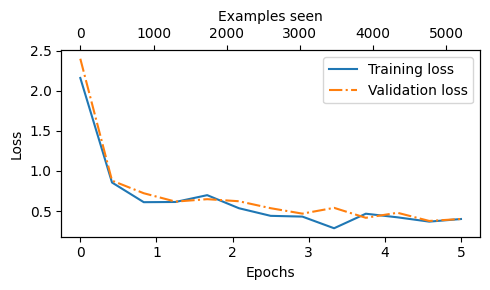

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [ ]:
# without optional evaluation

# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            # if global_step % eval_freq == 0:
            #     train_loss, val_loss = evaluate_model(
            #         model, train_loader, val_loader, device, eval_iter)
            #     train_losses.append(train_loss)
            #     val_losses.append(val_loss)
            #     print(f"Ep {epoch+1} (Step {global_step:06d}): "
            #           f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 1
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    gpt, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Training accuracy: 85.00% | Validation accuracy: 82.50%
Training completed in 0.15 minutes.


In [ ]:
gpt.eval()
test_accuracy = calc_accuracy_loader(test_loader, gpt, device)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Test accuracy: 84.00%


In [ ]:
gpt.eval()
with torch.no_grad():
    test_loss = calc_loss_loader(test_loader, gpt, device)
print(f"Test loss: {test_loss:.3f}")

Test loss: 0.378


In [ ]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.positional_embedding.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [ ]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, gpt, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [ ]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, gpt, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [ ]:
optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.1)
torch.save({
    "model_state_dict": gpt.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

Created by **Md. Shadikur Rahman Sheam**.
- [Linkedin](https://www.linkedin.com/in/md-shadikur-rahman-sheam-3826482b3/)
- [Github](https://github.com/sadikurSenpai)
- [Facebook](https://www.facebook.com/profile.php?id=100091833665881)

Special thanks to Sebastian Raschka for his amazing book.